## Initialization

### Import

In [145]:
#
import os
import numpy as np
import importlib
import matplotlib.pyplot as plt
from constants import EnvironmentPath
import calculations as calculations
import WK99_signal_processing as signal_processing
import plotter as plotter

In [146]:
filepath = os.path.join(EnvironmentPath.ABSOLUTE_PATH_ERA5, "v.nc")
# filepath = os.path.join(EnvironmentPath.ABSOLUTE_PATH_SATELLITE_TEST, "OLR_detrended.nc")
data = calculations.Dataset(filepath)

In [147]:
# def default_taper():
#     """Generate default Hanning-like taper over first and last third of the segment."""
#     taper_window = np.zeros(len(longitudes))

#     window = np.hanning(np.argmax(longitudes >= 100) - np.argmax(longitudes >= 30))
#     taper_window[np.argmax(longitudes >= 30) : np.argmax(longitudes >= 100)] = window
#     return taper_window


# taper_window = default_taper()

In [148]:
def process_vorticity_in_chunks(data, chunk_size):
    """
    Process vorticity data in chunks to reduce memory usage. Applies symmetric and antisymmetric decomposition,
    crops the data by a latitude mask, and stores the results.

    Parameters:
    -----------
    data : netCDF4.Dataset or similar object
        The dataset containing the 'svo' variable (vorticity).
    taper_window : ndarray
        The taper window to apply to the vorticity data.
    latitude_mask : ndarray
        Boolean array that specifies which latitudes to retain after cropping.
    chunk_size : int
        The size of the chunks to process at a time (number of time steps).

    Returns:
    --------
    vorticity_symmetric_all : ndarray
        The symmetric component of vorticity, processed and cropped.
    vorticity_antisymmetric_all : ndarray
        The antisymmetric component of vorticity, processed and cropped.
    """
    times = data["time"][:]
    longitudes = data["lon"][:]
    latitudes = data["lat"][:]
    # pressure_levels = data["plev"][:] / 100

    latitude_mask = (latitudes > 0) & (latitudes < 20)
    longitude_mask = (longitudes > 45) & (longitudes < 90)
    latitudes = latitudes[latitude_mask]
    longitudes = longitudes[longitude_mask]

    num_timesteps = len(times)
    vorticity_symmetric_all = []
    vorticity_antisymmetric_all = []

    # Process data in chunks
    for i in range(0, num_timesteps, chunk_size):
        # Determine the end of the chunk
        end = min(i + chunk_size, num_timesteps)
        # Read the chunk of vorticity data (tapered)
        # vorticity_chunk = data["olr"][i:end, :, :]
        vorticity_chunk = data["v"][i:end, 1, :, :]
        # Symmetric and antisymmetric decomposition for the chunk
        vorticity_symmetric_chunk, vorticity_antisymmetric_chunk = (
            signal_processing.decompose_symmetric_antisymmetric(vorticity_chunk, axis=1)
        )
        # Crop using the latitude mask
        vorticity_symmetric_chunk = vorticity_symmetric_chunk[:, latitude_mask, :]
        vorticity_antisymmetric_chunk = vorticity_antisymmetric_chunk[
            :, latitude_mask, :
        ]
        # Store the processed chunks in lists
        vorticity_symmetric_all.append(vorticity_symmetric_chunk)
        vorticity_antisymmetric_all.append(vorticity_antisymmetric_chunk)
    # Concatenate all chunks along the time axis
    vorticity_symmetric_all = np.concatenate(vorticity_symmetric_all, axis=0)
    vorticity_antisymmetric_all = np.concatenate(vorticity_antisymmetric_all, axis=0)

    return (
        vorticity_symmetric_all,
        vorticity_antisymmetric_all,
        (times, latitudes, longitudes),
    )

In [149]:
symmetric, antisymmetric, grids = process_vorticity_in_chunks(data, chunk_size=500)
# Symmetric and antisymmetric decomposition
# symmetric, antisymmetric = signal_processing.decompose_symmetric_antisymmetric(data["olr"][:], axis=1)
# times = data["time"][:]
# longitudes = data["lon"][:]
# latitudes = data["lat"][:]
# latitude_mask = (latitudes > -15) & (latitudes < 15)
# latitudes = latitudes[latitude_mask]
# symmetric, antisymmetric = symmetric[:,latitude_mask,:], antisymmetric[:,latitude_mask,:]
# grids = (times, latitudes, longitudes)

# Compute PSD for symmetric, antisymmetric, and total
psd_symmetric, spectral_grid = signal_processing.compute_stochastic_PSD(
    symmetric, grids
)
psd_antisymmetric, spectral_grid = signal_processing.compute_stochastic_PSD(
    antisymmetric, grids
)
psd_total = psd_symmetric + psd_antisymmetric

# Apply filtering to obtain background PSD
background_psd = signal_processing.apply_121_filter(
    signal_processing.apply_121_filter(psd_total / 2, axis=2, iterations=10), axis=0, iterations=10
)

# Dimensionalize frequency
# From nondimensional ordinary wavenumber to ordinary wavenumber
# (cycles) -->  (cycles/day)
spectral_grid = (spectral_grid[0] / 96, spectral_grid[1], spectral_grid[2])

(0.0, 0.5)

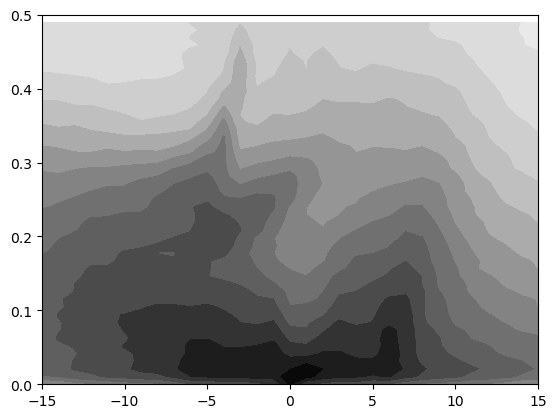

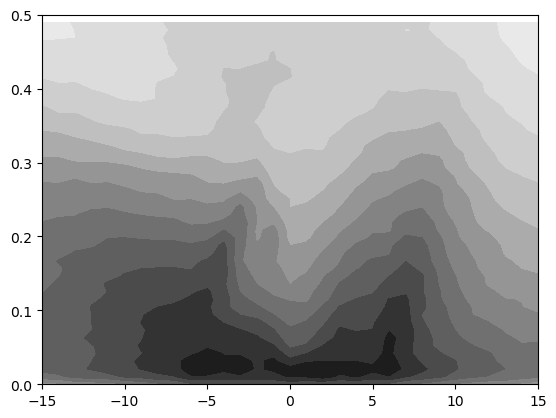

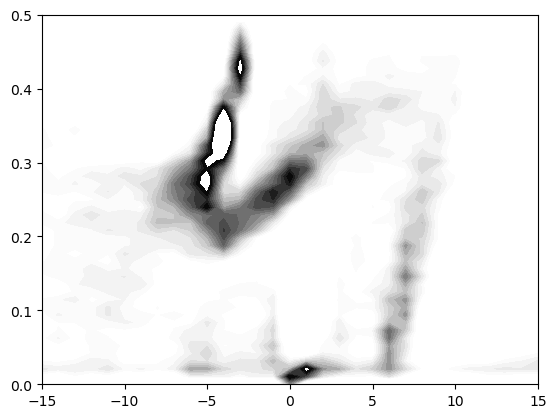

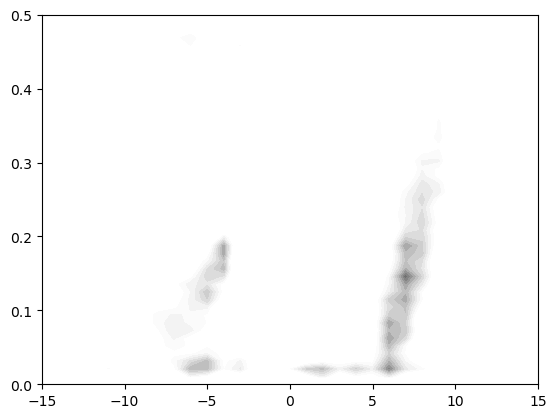

In [155]:
wavenum_indices = slice(
        np.argmax(spectral_grid[-1] >= -15),
        np.argmax(spectral_grid[-1] >= 15) + 1,
    )

plt.figure()
plt.contourf(spectral_grid[-1][wavenum_indices], spectral_grid[0], np.log10(np.sum(psd_symmetric[:,:,wavenum_indices], axis = 1)) , cmap = "Greys", levels = np.linspace(1,4,16))
# plt.
plt.xlim(-15,15)
plt.ylim(0,0.5)

plt.figure()
plt.contourf(spectral_grid[-1][wavenum_indices], spectral_grid[0], np.log10(np.sum(psd_antisymmetric[:,:,wavenum_indices], axis = 1)) , cmap = "Greys", levels = np.linspace(1,4,16))
# plt.
plt.xlim(-15,15)
plt.ylim(0,0.5)

plt.figure()
plt.contourf(spectral_grid[-1][wavenum_indices], spectral_grid[0], np.sum(psd_symmetric[:,:,wavenum_indices], axis = 1) / np.sum(background_psd[:,:,wavenum_indices], axis = 1), cmap = "Greys", levels = np.linspace(1.1,2,16))
# plt.
plt.xlim(-15,15)
plt.ylim(0,0.5)

plt.figure()
plt.contourf(spectral_grid[-1][wavenum_indices], spectral_grid[0], np.sum(psd_antisymmetric[:,:,wavenum_indices], axis = 1) / np.sum(background_psd[:,:,wavenum_indices], axis = 1), cmap = "Greys", levels = np.linspace(1.1,2,16))
# plt.
plt.xlim(-15,15)
plt.ylim(0,0.5)